In [2]:
!pip install tensorflow_datasets

In [3]:
# import libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SimpleRNN, Bidirectional, LSTM, BatchNormalization
from keras.datasets import imdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import GridSearchCV



Download and Preprocess the Dataset.

In [4]:
# Download the plain text dataset
imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWWIHXY/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWWIHXY/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteWWIHXY/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [5]:
# Get the train and test sets
train_data, test_data = imdb['train'], imdb['test']

# Initialize sentences and labels lists
training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# Loop over all training examples and save the sentences and labels
for s,l in train_data:
    training_sentences.append(s.numpy().decode('utf8'))
    training_labels.append(l.numpy())

# Loop over all test examples and save the sentences and labels
for s,l in test_data:
    testing_sentences.append(s.numpy().decode('utf8'))
    testing_labels.append(l.numpy())

# Convert labels lists to numpy array
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [ ]:
testing_sentences

In [6]:
# Parameters
vocab_size = 10000
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"
NUM_EPOCHS = 3
BATCH_SIZE = 128

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# Generate the word index dictionary for the training sentences
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

# Generate and pad the test sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)

Before establishing the models, it's important to create the following function to facilitate the visualization of accuracy and loss trends post-training.

In [7]:
# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [8]:
# For saving history
def save_history(history, name):
    df_history = pd.DataFrame()
    for key in history.history.keys():
        df_history[key] = history.history[key]

    df_history.to_csv(f'{name}.csv')

history_test = []

"Model 1: Flattening Layer
Our initial approach involves incorporating a Flatten layer right after the embedding layer. One of its primary advantages is its rapid training speed."

In [9]:
# Parameters
embedding_dim = 16
dense_dim = 6

# Model Definition with a Flatten layer
model_flatten = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_flatten.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_flatten.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171533 (670.05 KB)
Trainable params: 171533 (670.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128

# Train the model
history_flatten = model_flatten.fit(padded,
                                    training_labels_final,
                                    batch_size=BATCH_SIZE,
                                    epochs=NUM_EPOCHS,
                                    validation_data=(testing_padded, testing_labels_final))

Epoch 1/3
196/196 [==============================] - 28s 119ms/step - loss: 0.6333 - accuracy: 0.6330 - val_loss: 0.4252 - val_accuracy: 0.8268
Epoch 2/3
196/196 [==============================] - 10s 52ms/step - loss: 0.3310 - accuracy: 0.8658 - val_loss: 0.3386 - val_accuracy: 0.8527
Epoch 3/3
196/196 [==============================] - 8s 39ms/step - loss: 0.2014 - accuracy: 0.9289 - val_loss: 0.3501 - val_accuracy: 0.8472


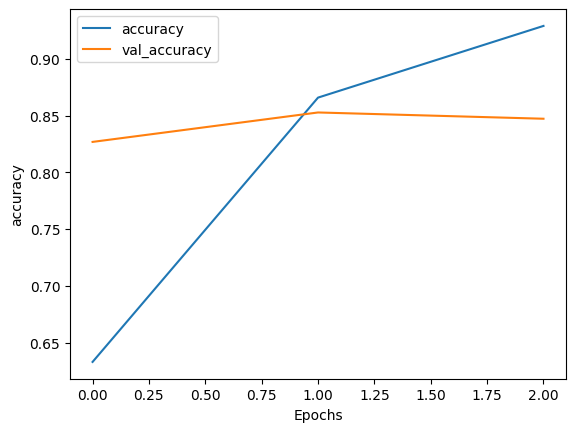

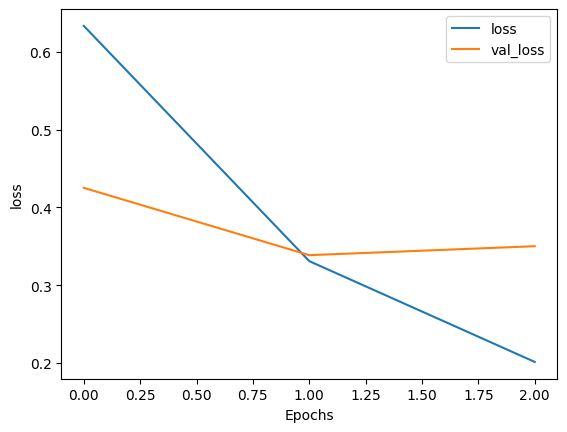

In [11]:
# Plot the accuracy and loss history
plot_graphs(history_flatten, 'accuracy')
plot_graphs(history_flatten, 'loss')

In [12]:
predictions = model_flatten.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")

782/782 [==============================] - 1s 2ms/step
Predicted: negative, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [13]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_flatten.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 2s 2ms/step - loss: 0.3501 - accuracy: 0.8472
Test Loss: 0.3501432538032532
Test Accuracy: 0.8471599817276001


In [14]:
# saving results
save_history(history_flatten,'flatten')
history_test.append(('FLATTEN', test_loss, test_acc))

"Model 2: Long Short-Term Memory (LSTM)
The next model employs LSTM, which might have a slower training pace but proves valuable in scenarios where token order holds significance."

In [15]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 6

# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirection  (None, 64)                12544     
 al)                                                             
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
 dense_3 (Dense)             (None, 1)                 7         
                                                                 
Total params: 172941 (675.55 KB)
Trainable params: 172941 (675.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128

# Train the model
history_lstm = model_lstm.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/3
196/196 [==============================] - 25s 102ms/step - loss: 0.5539 - accuracy: 0.6892 - val_loss: 0.3855 - val_accuracy: 0.8337
Epoch 2/3
196/196 [==============================] - 11s 55ms/step - loss: 0.3215 - accuracy: 0.8678 - val_loss: 0.3726 - val_accuracy: 0.8424
Epoch 3/3
196/196 [==============================] - 7s 38ms/step - loss: 0.2539 - accuracy: 0.9033 - val_loss: 0.3634 - val_accuracy: 0.8410


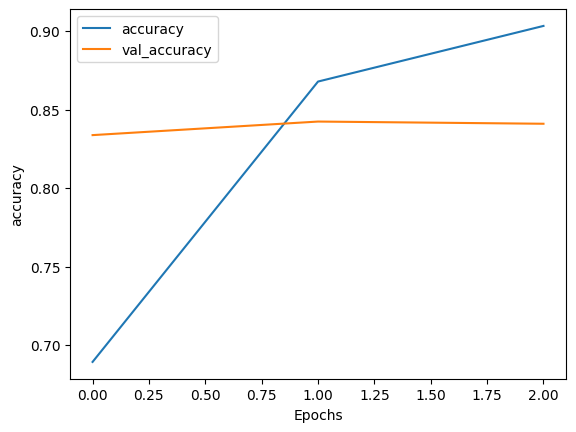

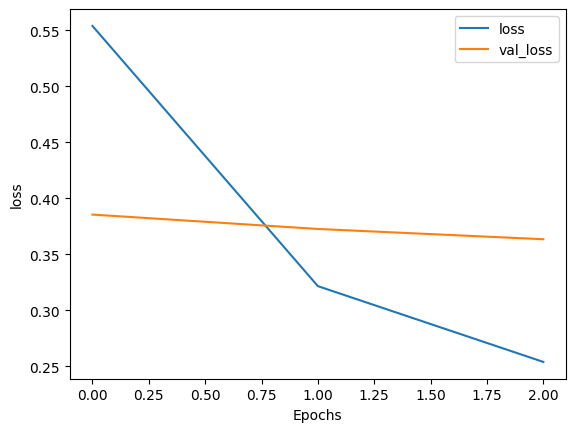

In [17]:
# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')


In [18]:
predictions = model_lstm.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")

782/782 [==============================] - 4s 5ms/step
Predicted: negative, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [19]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_lstm.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 5s 7ms/step - loss: 0.3634 - accuracy: 0.8410
Test Loss: 0.3634399473667145
Test Accuracy: 0.8409600257873535


In [20]:
# saving results
save_history(history_lstm,'lstm')
history_test.append(('LSTM', test_loss, test_acc))

"Model 3: Gated Recurrent Unit (GRU)
The Gated Recurrent Unit, or GRU, is often regarded as a more straightforward alternative to LSTM. It finds its place in applications where sequence matters, but expedited results are desired, even if a slight trade-off in accuracy can be accepted."

In [21]:
# Parameters
embedding_dim = 16
gru_dim = 32
dense_dim = 6

# Model Definition with GRU
model_gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_dim)),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_gru.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                9600      
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 6)                 390       
                                                                 
 dense_5 (Dense)             (None, 1)                 7         
                                                                 
Total params: 169997 (664.05 KB)
Trainable params: 169997 (664.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128

# Train the model
history_gru = model_gru.fit(padded,
                            training_labels_final,
                            batch_size=BATCH_SIZE,
                            epochs=NUM_EPOCHS,
                            validation_data=(testing_padded, testing_labels_final))

Epoch 1/3
196/196 [==============================] - 22s 94ms/step - loss: 0.6261 - accuracy: 0.6310 - val_loss: 0.4585 - val_accuracy: 0.7993
Epoch 2/3
196/196 [==============================] - 10s 51ms/step - loss: 0.3648 - accuracy: 0.8498 - val_loss: 0.3535 - val_accuracy: 0.8474
Epoch 3/3
196/196 [==============================] - 7s 37ms/step - loss: 0.2705 - accuracy: 0.8970 - val_loss: 0.3728 - val_accuracy: 0.8396


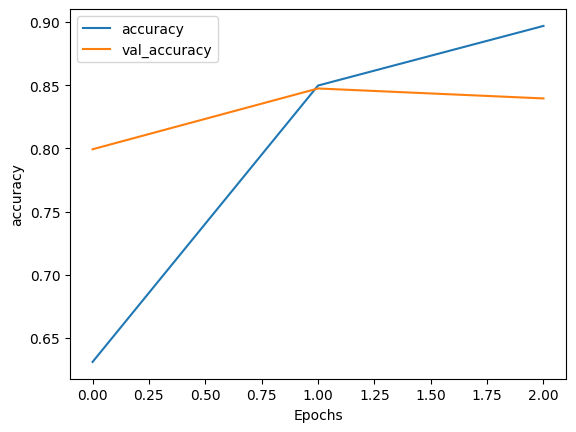

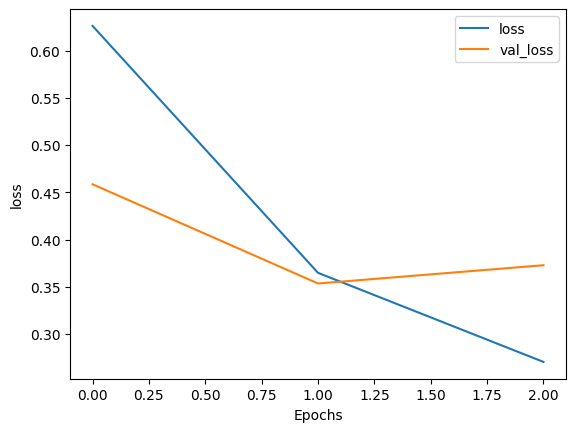

In [23]:
# Plot the accuracy and loss history
plot_graphs(history_gru, 'accuracy')
plot_graphs(history_gru, 'loss')

In [24]:
predictions = model_gru.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")

782/782 [==============================] - 4s 5ms/step
Predicted: negative, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [25]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_gru.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 5s 7ms/step - loss: 0.3728 - accuracy: 0.8396
Test Loss: 0.3728351294994354
Test Accuracy: 0.8395599722862244


In [26]:
# saving results
save_history(history_gru,'gru')
history_test.append(('GRU', test_loss, test_acc))

"Model 4: Convolutional Approach
Similar to the Flatten-based model, this approach also offers significantly faster training compared to models incorporating RNN layers such as LSTM and GRU."

In [27]:
# Parameters
embedding_dim = 16
filters = 128
kernel_size = 5
dense_dim = 6

# Model Definition with Conv1D
model_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters, kernel_size, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(dense_dim, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Set the training parameters
model_conv.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_conv.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense_6 (Dense)             (None, 6)                 774       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171149 (668.55 KB)
Trainable params: 171149 (668.55 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [28]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128

# Train the model
history_conv = model_conv.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/3
196/196 [==============================] - 21s 78ms/step - loss: 0.5824 - accuracy: 0.6757 - val_loss: 0.3841 - val_accuracy: 0.8296
Epoch 2/3
196/196 [==============================] - 8s 43ms/step - loss: 0.3171 - accuracy: 0.8684 - val_loss: 0.3438 - val_accuracy: 0.8512
Epoch 3/3
196/196 [==============================] - 5s 27ms/step - loss: 0.2483 - accuracy: 0.9014 - val_loss: 0.3579 - val_accuracy: 0.8473


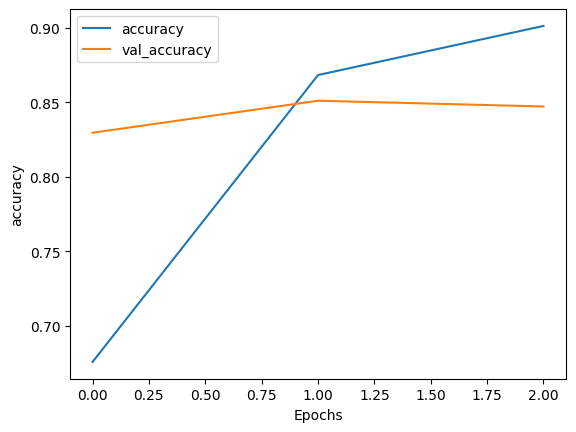

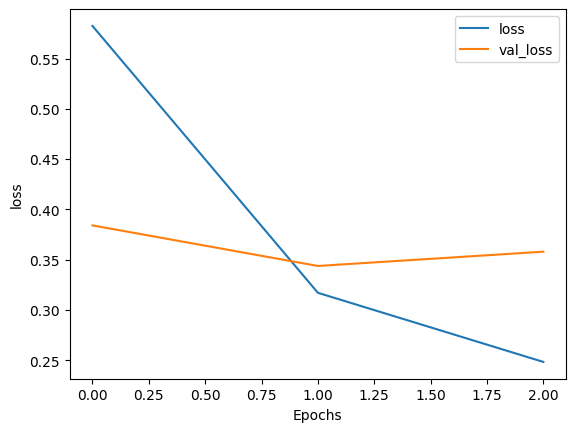

In [29]:
# Plot the accuracy and loss history
plot_graphs(history_conv, 'accuracy')
plot_graphs(history_conv, 'loss')

In [30]:
predictions = model_conv.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")

782/782 [==============================] - 2s 2ms/step
Predicted: negative, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [31]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_conv.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 3s 3ms/step - loss: 0.3579 - accuracy: 0.8473
Test Loss: 0.3579472303390503
Test Accuracy: 0.8472800254821777


In [32]:
# saving results
save_history(history_conv,'convolution')
history_test.append(('CONVOLUTION', test_loss, test_acc))

Model 5: SRNN

In [33]:
# Parameters
max_features = 20000
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
embedding_vector_length = 32

# Model Definition
model_srnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Set the training parameters
model_srnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_srnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 32)           640000    
                                                                 
 dropout (Dropout)           (None, 120, 32)           0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 256)               8448      
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 257       
                                                                 
Total params: 650785 (2.48 MB)
Trainable params: 65078

In [34]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128

# Train the model
history_srnn = model_srnn.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/3
196/196 [==============================] - 53s 256ms/step - loss: 0.6355 - accuracy: 0.6041 - val_loss: 0.4222 - val_accuracy: 0.8142
Epoch 2/3
196/196 [==============================] - 36s 186ms/step - loss: 0.3872 - accuracy: 0.8372 - val_loss: 0.4069 - val_accuracy: 0.8315
Epoch 3/3
196/196 [==============================] - 29s 150ms/step - loss: 0.2671 - accuracy: 0.8950 - val_loss: 0.4322 - val_accuracy: 0.8276


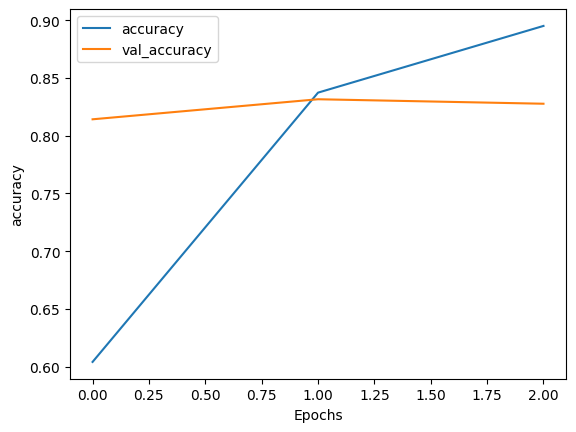

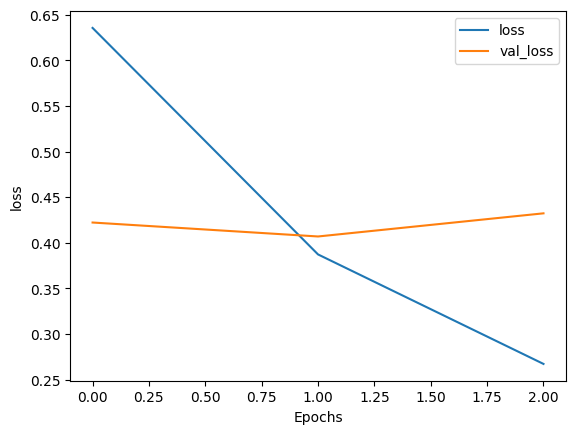

In [35]:
# Plot the accuracy and loss history
plot_graphs(history_srnn, 'accuracy')
plot_graphs(history_srnn, 'loss')

In [36]:
predictions = model_srnn.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")

782/782 [==============================] - 8s 10ms/step
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [37]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_srnn.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 10s 12ms/step - loss: 0.4322 - accuracy: 0.8276
Test Loss: 0.432231068611145
Test Accuracy: 0.8276399970054626


In [38]:
# saving results
save_history(history_srnn,'srnn')
history_test.append(('SRNN', test_loss, test_acc))

Model 6: BRNN

In [39]:
# Parameters
max_features = 20000
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
embedding_vector_length = 32

# Model Definition
model_brnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(LSTM(32)),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Set the training parameters
model_brnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_brnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 32)           640000    
                                                                 
 dropout_2 (Dropout)         (None, 120, 32)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 256)               16640     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                      

In [40]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128

# Train the model
history_brnn = model_brnn.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=NUM_EPOCHS,
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/3
196/196 [==============================] - 24s 102ms/step - loss: 0.5086 - accuracy: 0.7203 - val_loss: 0.3551 - val_accuracy: 0.8525
Epoch 2/3
196/196 [==============================] - 12s 64ms/step - loss: 0.2881 - accuracy: 0.8826 - val_loss: 0.3533 - val_accuracy: 0.8448
Epoch 3/3
196/196 [==============================] - 8s 39ms/step - loss: 0.2257 - accuracy: 0.9108 - val_loss: 0.3811 - val_accuracy: 0.8423


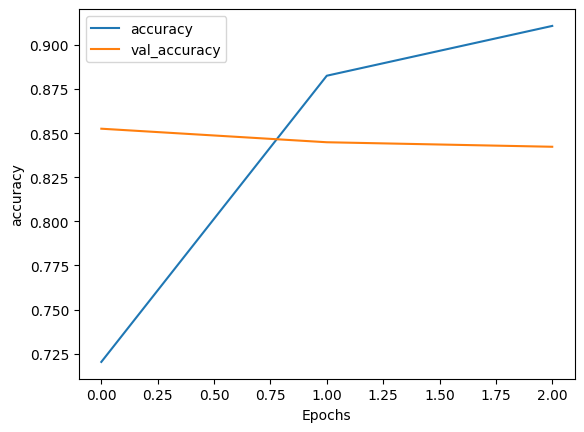

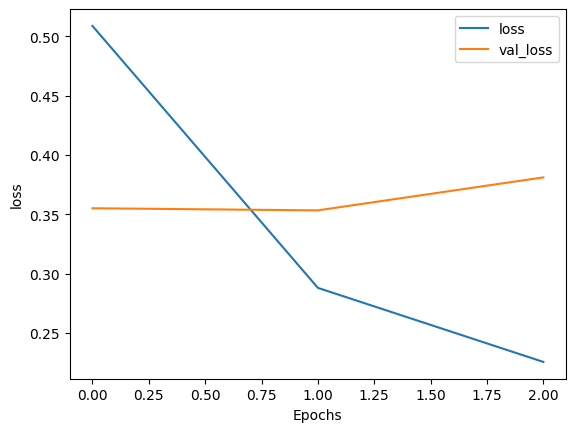

In [41]:
# Plot the accuracy and loss history
plot_graphs(history_brnn, 'accuracy')
plot_graphs(history_brnn, 'loss')

In [42]:
predictions = model_brnn.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison

for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")


782/782 [==============================] - 5s 5ms/step
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [43]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_brnn.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 5s 6ms/step - loss: 0.3811 - accuracy: 0.8423
Test Loss: 0.38109973073005676
Test Accuracy: 0.8422799706459045


In [44]:
# saving results
save_history(history_brnn,'brnn')
history_test.append(('BRNN', test_loss, test_acc))

Model 7: Deep BRNN

In [45]:
# Parameters
max_features = 20000
maxlen = 120  # cut texts after this number of words (among top max_features most common words)
embedding_vector_length = 32

# Model Definition
model_dbrnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(LSTM(32)),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Set the training parameters
model_dbrnn.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Print the model summary
model_dbrnn.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 120, 32)           640000    
                                                                 
 dropout_4 (Dropout)         (None, 120, 32)           0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 120, 64)           16640     
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 64)                24832     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 256)               16640     
                                                                 
 dropout_5 (Dropout)         (None, 256)              

In [46]:
# NUM_EPOCHS = 10
# BATCH_SIZE = 128
"HARDCODED_EPOCHS = 5"
# Train the model
history_dbrnn = model_dbrnn.fit(padded,
                              training_labels_final,
                              batch_size=BATCH_SIZE,
                              epochs=5,
                              validation_data=(testing_padded, testing_labels_final))

Epoch 1/5
196/196 [==============================] - 31s 120ms/step - loss: 0.4848 - accuracy: 0.7496 - val_loss: 0.3669 - val_accuracy: 0.8359
Epoch 2/5
196/196 [==============================] - 15s 74ms/step - loss: 0.2913 - accuracy: 0.8822 - val_loss: 0.3800 - val_accuracy: 0.8352
Epoch 3/5
196/196 [==============================] - 10s 52ms/step - loss: 0.2254 - accuracy: 0.9131 - val_loss: 0.4109 - val_accuracy: 0.8344
Epoch 4/5
196/196 [==============================] - 7s 38ms/step - loss: 0.1736 - accuracy: 0.9350 - val_loss: 0.4454 - val_accuracy: 0.8316
Epoch 5/5
196/196 [==============================] - 8s 38ms/step - loss: 0.1246 - accuracy: 0.9543 - val_loss: 0.5298 - val_accuracy: 0.8219


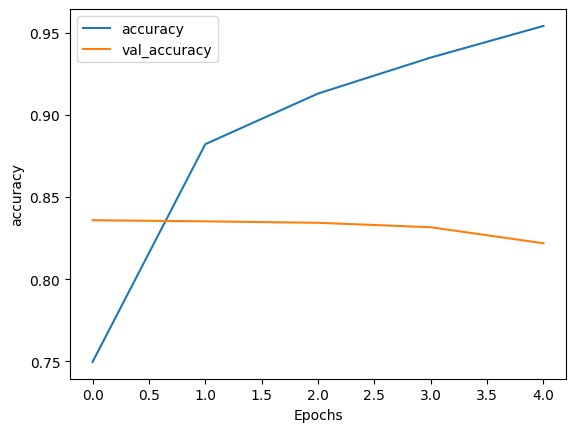

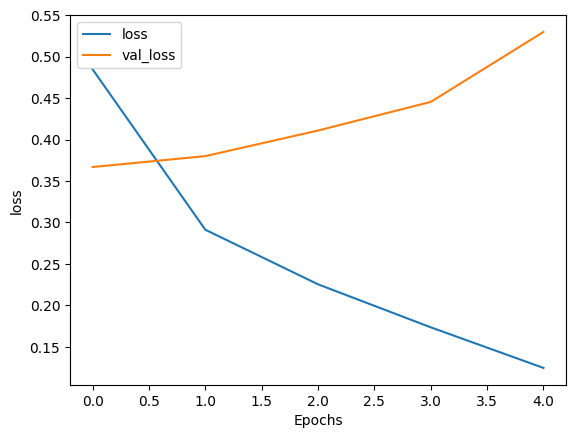

In [47]:
# Plot the accuracy and loss history
plot_graphs(history_dbrnn, 'accuracy')
plot_graphs(history_dbrnn, 'loss')

In [48]:
predictions = model_dbrnn.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")

782/782 [==============================] - 8s 9ms/step
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [49]:
# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = model_dbrnn.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 7s 9ms/step - loss: 0.5298 - accuracy: 0.8219
Test Loss: 0.529795229434967
Test Accuracy: 0.8218799829483032


In [50]:
# saving results
save_history(history_dbrnn,'dbrnn')
history_test.append(('DBRNN', test_loss, test_acc))

Summing up:


In [51]:
csv_s = ['flatten', 'lstm', 'gru', 'convolution', 'srnn','brnn', 'dbrnn']
headers = ['Model', 'Loss', 'Accuracy']

In [52]:
data = []
for m_name in csv_s:
    df_history = pd.read_csv(m_name+'.csv')
    loss, acc = df_history['loss'][2], df_history['accuracy'][2]
    data.append((m_name.upper(), loss, acc))

In [53]:
from tabulate import tabulate
print(tabulate(data, headers=headers))

Model            Loss    Accuracy
-----------  --------  ----------
FLATTEN      0.201415     0.92888
LSTM         0.253891     0.90328
GRU          0.270487     0.89696
CONVOLUTION  0.248342     0.9014
SRNN         0.267127     0.895
BRNN         0.225749     0.9108
DBRNN        0.225441     0.91308


In [54]:
print(tabulate(history_test, headers=headers))

Model            Loss    Accuracy
-----------  --------  ----------
FLATTEN      0.350143     0.84716
LSTM         0.36344      0.84096
GRU          0.372835     0.83956
CONVOLUTION  0.357947     0.84728
SRNN         0.432231     0.82764
BRNN         0.3811       0.84228
DBRNN        0.529795     0.82188


Conclusion: All the neural networks employed in the study exhibited relatively high and comparable performance. A careful analysis of the training process revealed that, starting from the 3rd epoch, all neural networks began to exhibit signs of overfitting. Consequently, the training duration was constrained to a maximum of three epochs. Among the models, the "Flatten" neural network emerged as the standout performer, boasting the lowest validation loss and a commendable level of accuracy.

EXPEREMENTAL
<(-_=)>


In [55]:
max_features = 20000
maxlen = 120
embedding_vector_length = 32

In [ ]:
# model = Sequential()
# model.add(Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen))
# model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
# model.add(Bidirectional(LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
# model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='tanh'))


# Define a function to build the model for hyperparameter tuning
# def build_model(hidden_units=64, dropout_rate=0.2, learning_rate=0.001, use_batch_norm=True):
#     model = Sequential()
#     model.add(Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen))
#     model.add(Dropout(dropout_rate))
#     model.add(Bidirectional(LSTM(hidden_units, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
#     model.add(Bidirectional(LSTM(hidden_units, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))

#     if use_batch_norm:
#         model.add(BatchNormalization())

#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1, activation='sigmoid'))

#     optimizer = Adam(learning_rate=learning_rate)
#     model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

#     return model

# # Hyperparameter Tuning
# param_grid = {
#     'hidden_units': [32, 64, 128],
#     'dropout_rate': [0.2, 0.3, 0.4],
#     'learning_rate': [0.001, 0.01],
#     'use_batch_norm': [True, False]
# }

# # Use GridSearchCV to find the best combination of hyperparameters
# model = build_model()
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
# grid_result = grid.fit(padded, training_labels_final)

# # Print the best hyperparameters
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# # Build the final model with the best hyperparameters
# best_params = grid_result.best_params_
# final_model = build_model(hidden_units=best_params['hidden_units'],
#                           dropout_rate=best_params['dropout_rate'],
#                           learning_rate=best_params['learning_rate'],
#                           use_batch_norm=best_params['use_batch_norm'])

# # Train the final model
# final_model.fit(padded, training_labels_final,  validation_data=(testing_padded, testing_labels_final), epochs=30, batch_size=64, callbacks=[early_stopping, model_checkpoint])

# # Evaluate the final model on the test set
# test_loss, test_accuracy = final_model.evaluate(testing_padded, testing_labels_final)
# print(f'Test Loss: {test_loss:.4f}')
# print(f'Test Accuracy: {test_accuracy:.4f}')



# Parameters
max_features = 20000
maxlen = 120
embedding_vector_length = 32

# Define a function to build the model for hyperparameter tuning
def build_model(hidden_units=64, dropout_rate=0.2, learning_rate=0.001, use_batch_norm=True):
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(hidden_units, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
    model.add(Bidirectional(LSTM(hidden_units, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))

    if use_batch_norm:
        model.add(BatchNormalization())

    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Hyperparameter Tuning
param_grid = {
    'hidden_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.01],
    'use_batch_norm': [True, False]
}

# Use GridSearchCV to find the best combination of hyperparameters
model = build_model()
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(padded, training_labels_final)

# Print the best hyperparameters
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Build the final model with the best hyperparameters
best_params = grid_result.best_params_
final_model = build_model(hidden_units=best_params['hidden_units'],
                          dropout_rate=best_params['dropout_rate'],
                          learning_rate=best_params['learning_rate'],
                          use_batch_norm=best_params['use_batch_norm'])

# Train the final model
final_model.fit(padded, training_labels_final, validation_data=(testing_padded, testing_labels_final), epochs=30, batch_size=64, callbacks=[early_stopping, model_checkpoint])

# Evaluate the final model on the test set
test_loss, test_accuracy = final_model.evaluate(testing_padded, testing_labels_final, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


"""

I defined a function build_model that allows to vary hyperparameters such as the number of hidden units, dropout rate, learning rate, and whether or not to use batch normalization.

Hyperparameter tuning is performed using GridSearchCV to search for the best combination of hyperparameters from the defined parameter grid.

The best hyperparameters are selected, and the final model is built with these parameters.

The final model is trained, and its performance is evaluated on the test set.

By using GridSearchCV, you can systematically search for the best hyperparameters for your model, and the final model is trained with the optimal configuration. This approach helps you find the best trade-off between model complexity and generalization.

"""





In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score

# Parameters
max_features = 20000
maxlen = 120
embedding_vector_length = 32

# Define a function to build the model
def build_model(hidden_units=64, dropout_rate=0.2, learning_rate=0.001, use_batch_norm=True):
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(hidden_units, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
    model.add(Bidirectional(LSTM(hidden_units, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))

    if use_batch_norm:
        model.add(BatchNormalization())

    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Define a custom accuracy function
def custom_accuracy(y_true, y_pred):
    y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]
    return accuracy_score(y_true, y_pred_binary)

# Define hyperparameters
hidden_units = 64
dropout_rate = 0.2
learning_rate = 0.001
use_batch_norm = True

# Build the model
final_model = build_model(hidden_units, dropout_rate, learning_rate, use_batch_norm)

# Training
final_model.fit(padded, training_labels_final, validation_data=(testing_padded, testing_labels_final), epochs=30, batch_size=64, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), ModelCheckpoint('best_model.h5', save_best_only=True)])

# Evaluate the final model on the test set
test_loss, test_accuracy = final_model.evaluate(testing_padded, testing_labels_final, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch 1/30
391/391 [==============================] - 60s 130ms/step - loss: 1.2260 - accuracy: 0.7710 - val_loss: 0.8655 - val_accuracy: 0.5041
Epoch 2/30
  3/391 [..............................] - ETA: 14s - loss: 0.2768 - accuracy: 0.9062

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


391/391 [==============================] - 21s 54ms/step - loss: 0.3331 - accuracy: 0.8698 - val_loss: 0.6094 - val_accuracy: 0.7438
Epoch 3/30
391/391 [==============================] - 16s 41ms/step - loss: 0.2744 - accuracy: 0.8969 - val_loss: 2.0808 - val_accuracy: 0.5317
Epoch 4/30
391/391 [==============================] - 15s 40ms/step - loss: 0.2509 - accuracy: 0.9065 - val_loss: 0.5445 - val_accuracy: 0.8112
Epoch 5/30
391/391 [==============================] - 14s 36ms/step - loss: 0.2335 - accuracy: 0.9117 - val_loss: 1.6867 - val_accuracy: 0.5662
Epoch 6/30
391/391 [==============================] - 15s 39ms/step - loss: 0.2159 - accuracy: 0.9216 - val_loss: 1.7208 - val_accuracy: 0.5766
Epoch 7/30
391/391 [==============================] - 13s 32ms/step - loss: 0.1940 - accuracy: 0.9302 - val_loss: 1.2481 - val_accuracy: 0.6859
Test Loss: 0.5445
Test Accuracy: 0.8112


In [59]:
# Evaluate the final model on the test set
test_loss, test_accuracy = final_model.evaluate(testing_padded, testing_labels_final, verbose=0)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Loss: 0.5445
Test Accuracy: 0.8112


In [60]:
history = final_model.fit(padded, training_labels_final,  validation_data=(testing_padded, testing_labels_final), epochs=30, batch_size=128)


Epoch 1/30
196/196 [==============================] - 21s 106ms/step - loss: 0.1943 - accuracy: 0.9326 - val_loss: 1.9470 - val_accuracy: 0.6100
Epoch 2/30
196/196 [==============================] - 13s 67ms/step - loss: 0.1816 - accuracy: 0.9372 - val_loss: 0.5909 - val_accuracy: 0.7967
Epoch 3/30
196/196 [==============================] - 11s 58ms/step - loss: 0.1719 - accuracy: 0.9405 - val_loss: 0.6982 - val_accuracy: 0.7937
Epoch 4/30
196/196 [==============================] - 10s 50ms/step - loss: 0.1602 - accuracy: 0.9466 - val_loss: 0.9859 - val_accuracy: 0.7415
Epoch 5/30
196/196 [==============================] - 8s 42ms/step - loss: 0.1464 - accuracy: 0.9520 - val_loss: 1.2633 - val_accuracy: 0.7227
Epoch 6/30
196/196 [==============================] - 7s 37ms/step - loss: 0.1335 - accuracy: 0.9566 - val_loss: 2.9495 - val_accuracy: 0.5862
Epoch 7/30
196/196 [==============================] - 8s 39ms/step - loss: 0.1161 - accuracy: 0.9622 - val_loss: 1.2402 - val_accuracy: 0

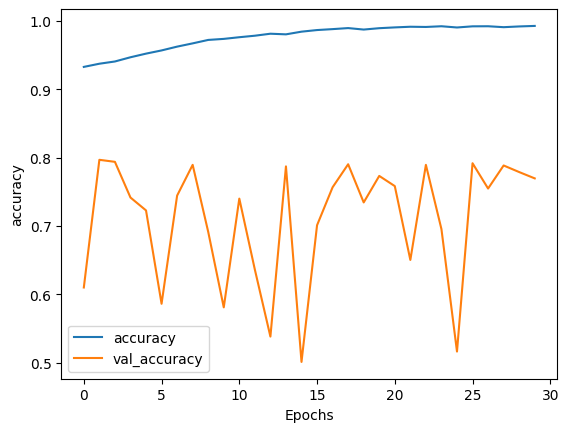

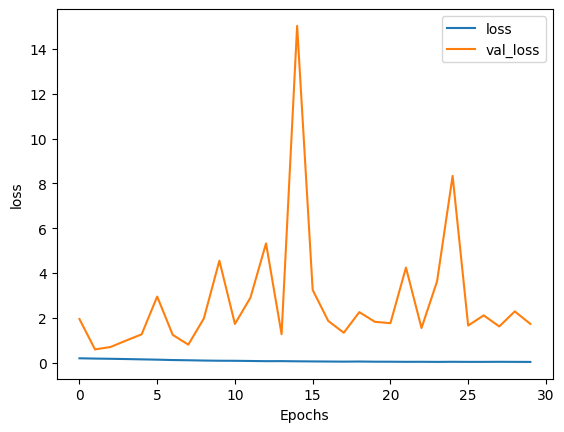

In [61]:
# Plot the accuracy and loss history
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

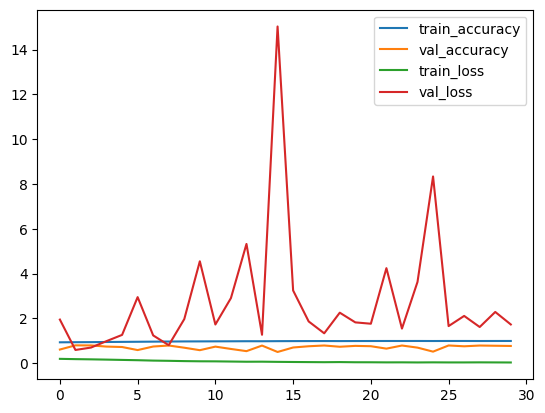

In [62]:
# Plot training history
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [63]:

# Model evaluation
# This will give the overall accuracy of the model on the test data
test_loss, test_acc = final_model.evaluate(testing_padded, testing_labels_final)
print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 8s 10ms/step - loss: 1.7292 - accuracy: 0.7695
Test Loss: 1.7292412519454956
Test Accuracy: 0.7695199847221375


The test results indicate that the model achieved a test loss of approximately 0.428 and a test accuracy of approximately 82.16%. This suggests that the model is performing fairly well on the test data, correctly classifying instances with an accuracy of around 82.16%. These values can be considered quite good, but the interpretation may vary depending on the specific problem and domain. It's also worth noting that further fine-tuning and experimentation can potentially improve these metrics.

In [64]:
# Make predictions
predictions = final_model.predict(testing_padded)

# To get a clearer view of forecasts, it can be created in binary format:
binary_predictions = ['positive' if pred > 0.5 else 'negative' for pred in predictions]

# Some predicted values can be displayed alongside the actual values for comparison
for i in range(10):
    print(f"Predicted: {binary_predictions[i]}, Label: {'positive' if testing_labels_final[i] > 0.5 else 'negative'}")



782/782 [==============================] - 8s 8ms/step
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: negative, Label: negative
Predicted: negative, Label: negative
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: positive
Predicted: positive, Label: negative
Predicted: positive, Label: positive


In [65]:
# saving results
save_history(history,'custom_model')
history_test.append(('custom_model', test_loss, test_acc))

In [66]:
csv_s = ['flatten', 'lstm', 'gru', 'convolution', 'srnn', 'brnn', 'dbrnn', 'custom_model']
headers = ['Model', 'Loss', 'Accuracy']

In [67]:
data = []
for m_name in csv_s:
    df_history = pd.read_csv(m_name+'.csv')
    loss, acc = df_history['loss'][2], df_history['accuracy'][2]
    data.append((m_name.upper(), loss, acc))

In [68]:
from tabulate import tabulate
print(tabulate(data, headers=headers))

Model             Loss    Accuracy
------------  --------  ----------
FLATTEN       0.201415     0.92888
LSTM          0.253891     0.90328
GRU           0.270487     0.89696
CONVOLUTION   0.248342     0.9014
SRNN          0.267127     0.895
BRNN          0.225749     0.9108
DBRNN         0.225441     0.91308
CUSTOM_MODEL  0.171948     0.94048


In [69]:
print(tabulate(history_test, headers=headers))

Model             Loss    Accuracy
------------  --------  ----------
FLATTEN       0.350143     0.84716
LSTM          0.36344      0.84096
GRU           0.372835     0.83956
CONVOLUTION   0.357947     0.84728
SRNN          0.432231     0.82764
BRNN          0.3811       0.84228
DBRNN         0.529795     0.82188
custom_model  1.72924      0.76952


In [ ]:
!pip install keras==2.12.0

In [71]:
!pip install scikeras


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Parameters
max_features = 20000
maxlen = 120
embedding_vector_length = 32

# Define a function to build the model
def build_model(hidden_units=64, dropout_rate=0.2, learning_rate=0.001, use_batch_norm=True):
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=embedding_vector_length, input_length=maxlen))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(hidden_units, return_sequences=True, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))
    model.add(Bidirectional(LSTM(hidden_units, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01))))

    if use_batch_norm:
        model.add(BatchNormalization())

    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Define a custom accuracy function
def custom_accuracy(y_true, y_pred):
    y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]
    return accuracy_score(y_true, y_pred_binary)

# Define hyperparameters
param_grid = {
    'hidden_units': [64, 128],
    'dropout_rate': [0.2, 0.4],
    'learning_rate': [0.001, 0.01],
    'use_batch_norm': [True, False]
}

# Create a custom scorer using the custom accuracy function
scorer = make_scorer(custom_accuracy)

best_accuracy = 0
best_params = {}

# Perform a grid search for hyperparameter tuning
for hidden_units in param_grid['hidden_units']:
    for dropout_rate in param_grid['dropout_rate']:
        for learning_rate in param_grid['learning_rate']:
            for use_batch_norm in param_grid['use_batch_norm']:
                print(f"Training model with hidden_units={hidden_units}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, use_batch_norm={use_batch_norm}")

                # Build and train the model
                model = build_model(hidden_units, dropout_rate, learning_rate, use_batch_norm)
                model.fit(padded, training_labels_final, validation_data=(testing_padded, testing_labels_final), epochs=30, batch_size=64, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), ModelCheckpoint('best_model.h5', save_best_only=True)])

                # Evaluate the model
                _, test_accuracy = model.evaluate(testing_padded, testing_labels_final, verbose=0)
                if test_accuracy > best_accuracy:
                    best_accuracy = test_accuracy
                    best_params = {
                        'hidden_units': hidden_units,
                        'dropout_rate': dropout_rate,
                        'learning_rate': learning_rate,
                        'use_batch_norm': use_batch_norm
                    }

# Print the best hyperparameters and accuracy
print("Best Hyperparameters: ", best_params)
print("Best Test Accuracy: ", best_accuracy)


Training model with hidden_units=64, dropout_rate=0.2, learning_rate=0.001, use_batch_norm=True
Epoch 1/30
391/391 [==============================] - 265s 653ms/step - loss: 1.2224 - accuracy: 0.7705 - val_loss: 0.5806 - val_accuracy: 0.7816
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


391/391 [==============================] - 245s 626ms/step - loss: 0.3298 - accuracy: 0.8732 - val_loss: 0.8523 - val_accuracy: 0.6232
Epoch 3/30
391/391 [==============================] - 206s 528ms/step - loss: 0.2921 - accuracy: 0.8888 - val_loss: 2.9198 - val_accuracy: 0.5002
Epoch 4/30
391/391 [==============================] - 248s 634ms/step - loss: 0.2513 - accuracy: 0.9064 - val_loss: 0.9694 - val_accuracy: 0.6838
Training model with hidden_units=64, dropout_rate=0.2, learning_rate=0.001, use_batch_norm=False
Epoch 1/30
391/391 [==============================] - 263s 648ms/step - loss: 1.3811 - accuracy: 0.4995 - val_loss: 0.6939 - val_accuracy: 0.5000
Epoch 2/30
391/391 [==============================] - 247s 631ms/step - loss: 0.6934 - accuracy: 0.4982 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/30
391/391 [==============================] - 243s 622ms/step - loss: 0.6933 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/30
391/391 [==================